In [1]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [2]:
nytimes = pd.read_csv('nytimes.csv')


In [3]:
nlp= spacy.load("en_core_web_lg")

# My list of stop words.
stop_list = ["Mrs.","Ms.","say","WASHINGTON","'s","Mr.",]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [4]:
#removing numbers
nytimes['lead_paragraph'] = nytimes['lead_paragraph'].str.replace("[^a-zA-Z#]", " ")

# removing short words
nytimes['lead_paragraph'] = nytimes['lead_paragraph'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
nytimes['lead_paragraph'] = nytimes['lead_paragraph'].apply(lambda x: x.lower())

In [5]:
newest_doc = nytimes['lead_paragraph']

In [6]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [7]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(newest_doc):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
doc_list

[['hostos',
  'community',
  'college',
  'south',
  'bronx',
  'locate',
  'census',
  'find',
  'nation',
  'poor',
  'congressional',
  'district',
  'people',
  'apply',
  'study',
  'nursing',
  'year',
  'bayside',
  'queens',
  'admissions',
  'officer',
  'queensborough',
  'community',
  'college',
  'flood',
  'application',
  'past',
  'month',
  'student',
  'recently',
  'obtain',
  'high',
  'school',
  'equivalency',
  'diploma',
  'trouble',
  'find',
  'work'],
 ['washington',
  'company',
  'spend',
  'million',
  'dollar',
  'year',
  'complain',
  'congress',
  'burdensome',
  'law',
  'regulation',
  'press',
  'concern',
  'public',
  'campaign',
  'private',
  'meeting',
  'rarely',
  'wait',
  'invitation',
  'month',
  'senior',
  'house',
  'republican',
  'representative',
  'darrell',
  'issa',
  'california',
  'dispatch',
  'letter',
  'company',
  'trade',
  'group',
  'research',
  'organization',
  'ask',
  'identify',
  'federal',
  'regulation',
  're

In [9]:

# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [10]:
# training LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=5,
                                           random_state=2,
                                           update_every=1,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
lda_model.show_topics()

[(0,
  '0.024*"president" + 0.013*"bush" + 0.011*"obama" + 0.009*"house" + 0.009*"clinton" + 0.008*"republican" + 0.007*"democrats" + 0.007*"economic" + 0.007*"senator" + 0.007*"campaign"'),
 (1,
  '0.017*"federal" + 0.012*"economic" + 0.010*"policy" + 0.010*"president" + 0.009*"economy" + 0.009*"budget" + 0.009*"reserve" + 0.009*"year" + 0.009*"administration" + 0.008*"reagan"'),
 (2,
  '0.017*"united" + 0.017*"states" + 0.014*"economic" + 0.013*"american" + 0.012*"economy" + 0.011*"world" + 0.007*"trade" + 0.007*"recession" + 0.007*"year" + 0.007*"business"'),
 (3,
  '0.010*"year" + 0.010*"company" + 0.006*"like" + 0.005*"people" + 0.005*"money" + 0.005*"business" + 0.005*"city" + 0.004*"market" + 0.004*"time" + 0.004*"million"'),
 (4,
  '0.032*"percent" + 0.019*"rate" + 0.017*"year" + 0.016*"report" + 0.015*"price" + 0.015*"rise" + 0.014*"month" + 0.012*"economy" + 0.009*"consumer" + 0.009*"market"')]

In [12]:
get_document_topics = [lda_model.get_document_topics(item, minimum_probability=0.1) for item in corpus]

In [13]:
get_document_topics

[[(3, 0.9836136)],
 [(0, 0.17320497), (1, 0.33828425), (2, 0.4802681)],
 [(0, 0.115004785), (1, 0.8777619)],
 [(1, 0.118367426), (2, 0.5361854), (3, 0.20299819), (4, 0.14120667)],
 [(0, 0.12430027), (2, 0.11570514), (4, 0.75197047)],
 [(2, 0.48441386), (4, 0.43588758)],
 [(2, 0.86499596), (3, 0.11589625)],
 [(3, 0.863859), (4, 0.1304982)],
 [(1, 0.65473664), (4, 0.3373343)],
 [(0, 0.1842626), (1, 0.805273)],
 [(2, 0.25115803), (4, 0.7416783)],
 [(4, 0.9786873)],
 [(2, 0.6114743), (3, 0.19287142), (4, 0.19231142)],
 [(2, 0.9686293)],
 [(0, 0.32748327), (1, 0.4403919), (3, 0.22687012)],
 [(0, 0.24685217), (2, 0.7480419)],
 [(1, 0.6456055), (3, 0.23407197), (4, 0.116737895)],
 [(1, 0.6086791), (2, 0.20683406), (4, 0.18163194)],
 [(4, 0.9882716)],
 [(1, 0.98604417)],
 [(4, 0.9834898)],
 [(1, 0.3886246), (2, 0.1652694), (3, 0.28074235)],
 [(4, 0.9776212)],
 [(0, 0.3349187), (2, 0.54137033), (3, 0.110491306)],
 [(0, 0.1526816), (1, 0.73350286), (4, 0.10924941)],
 [(1, 0.3060331), (2, 0.20048

In [14]:
top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / 5
print('Average topic coherence: %.4f.' % avg_topic_coherence)


Average topic coherence: -2.1404.


In [15]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, words)

/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/_pytest/mark/structures.py:351: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.258661  0.031037       1        1  36.344521
1     -0.000996  0.106332       2        1  24.026043
2      0.002540 -0.078853       3        1  14.575796
3      0.076977 -0.182967       4        1  13.226037
0      0.180140  0.124451       5        1  11.827600, topic_info=          Term         Freq        Total Category  logprob  loglift
350    percent  2531.000000  2531.000000  Default  30.0000  30.0000
99   president  1234.000000  1234.000000  Default  29.0000  29.0000
177      price  1173.000000  1173.000000  Default  28.0000  28.0000
362     report  1282.000000  1282.000000  Default  27.0000  27.0000
681     united   742.000000   742.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
167    economy   122.559135  1958.788452   Topic5  -5.3496  -0.6368
256       plan    84.891266   403.927460   Topic5  -5.7169   0.5749
23      people    81.528625   470.736206   Topic5  -5.7573   0.3814
103     reagan    81.574867   493.366943   Topic5  -5.7567   0.3350
34        year    83.485031  2429.598877   Topic5  -5.7336  -1.2361

[384 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
932       1  0.157671          abroad
932       3  0.823392          abroad
780       1  0.994231        activity
758       1  0.990795          adjust
74        1  0.031369  administration
...     ...       ...             ...
672       4  0.277030            york
672       5  0.170480            york
700       3  0.150559           young
700       4  0.733977           young
700       5  0.112920           young

[714 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

In [16]:
#hierarchical Dirichlet process
hdpmodel = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=words)

In [17]:
hdpmodel.show_topics(num_topics=6)

[(0,
  '0.013*percent + 0.012*year + 0.009*economy + 0.009*rate + 0.009*economic + 0.007*report + 0.006*month + 0.006*rise + 0.006*federal + 0.006*price + 0.005*market + 0.005*president + 0.005*today + 0.004*week + 0.004*increase + 0.004*billion + 0.004*government + 0.004*interest + 0.004*high + 0.004*business'),
 (1,
  '0.010*percent + 0.008*rate + 0.008*economy + 0.007*year + 0.006*economic + 0.005*market + 0.005*report + 0.005*federal + 0.005*month + 0.004*today + 0.004*rise + 0.004*interest + 0.004*price + 0.003*reserve + 0.003*president + 0.003*government + 0.003*increase + 0.003*business + 0.003*growth + 0.003*inflation'),
 (2,
  '0.005*president + 0.005*year + 0.005*economic + 0.004*economy + 0.004*market + 0.003*federal + 0.003*today + 0.003*rate + 0.003*house + 0.003*policy + 0.002*week + 0.002*budget + 0.002*republican + 0.002*bush + 0.002*reagan + 0.002*percent + 0.002*administration + 0.002*business + 0.002*billion + 0.002*like'),
 (3,
  '0.005*year + 0.005*economic + 0.004

In [18]:
# Training word2vec with the corpus
model = gensim.models.Word2Vec(doc_list, size=150, min_count=2, iter=10)

In [19]:
model.corpus_count

5000

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        if len(labels)==100:
            break;
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/bharatikakumani/Downloads/yes/envs/aivision/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` 

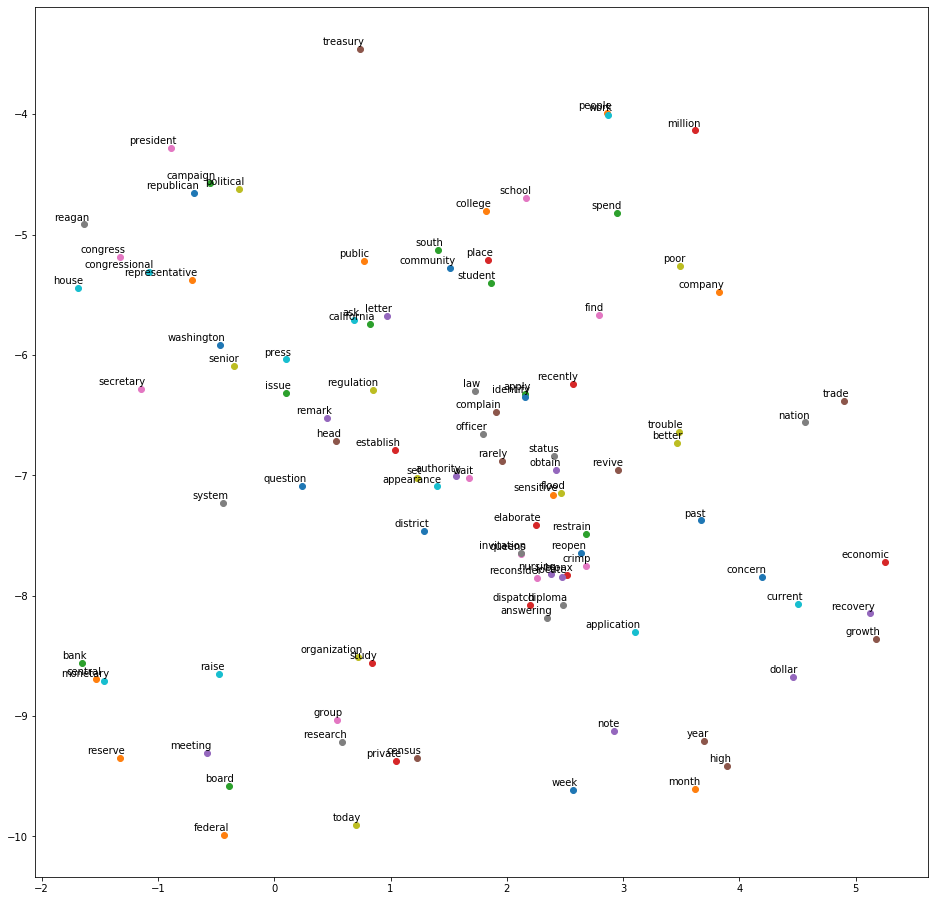

In [21]:

tsne_plot(model)